## 用决策树模型完成分类问题

#### 把需要的工具库import进来

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
# 显示整个cell的输出，而不需print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np


def calculate_acceleration(trajectory):
    # 假设trajectory是一系列经纬度点，计算加速度
    if len(trajectory) < 2:
        return 0, 0  # 如果轨迹点少于2个，则返回零加速度和角速度
    positions = np.array(trajectory)  # 转换为numpy数组

    # 计算速度（单位: m/s）
    distances = np.sqrt(np.sum(np.diff(positions, axis=0) ** 2, axis=1))  # 计算相邻点间的距离
    time_intervals = 30  # 时间间隔为30秒
    speeds = distances / time_intervals

    # 计算加速度（单位: m/s^2）
    accelerations = np.diff(speeds) / time_intervals

    # 计算角速度
    angles = np.arctan2(np.diff(positions[:, 1]), np.diff(positions[:, 0]))
    angular_velocities = np.diff(angles) / time_intervals

    # 返回最后一个加速度和角速度（可以选择其他方式合并）
    return accelerations[-1] if len(accelerations) > 0 else 0, angular_velocities[-1] if len(angular_velocities) > 0 else 0

#### 读取数据

In [4]:
from ast import literal_eval
import pandas as pd
import numpy as np

# adult_data = pd.read_csv("./DecisionTree.csv")

from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_columns", None)


def read_csv_by_pandas(filename):
    try:
        df = pd.read_csv(filename)
        df = df.dropna()
        # df['your_column'] = pd.to_numeric(df['your_column'], errors='coerce')
        print(f"文件 {filename} 读取成功, 共 {len(df)} 条数据.")
        print(df.shape)
        print(df["spec_index"].value_counts())
        
    except Exception as e:
        print(f"读取文件时出错: {e}")
        return None

    label_encoder = LabelEncoder()

    for column in ["ship_id","ship_true", "ship_type"]:
        df[column] = label_encoder.fit_transform(df[column])

    try:
        df["time"] = pd.to_datetime(df["time"]).astype("int64")
        df["weapons"] = df["weapons"].apply(literal_eval)
        df["trajectory"] = df["trajectory"].apply(literal_eval)
        df["score"] = df["score"].apply(literal_eval)
    except Exception as e:
        print(f"数据处理时出错: {e}")
        return None

    # 使用 assign 精简代码
    weapons_dummies = df["weapons"].apply(lambda x: pd.Series(1, index=x)).fillna(0)
    df = pd.concat([df, weapons_dummies], axis=1).drop(columns=["weapons"])
    print(df.shape)
    # 提取分数列
    score_cols = [
        "reconnaissance_score",
        "precision_score",
        "intercept_score",
        "jamming_score",
    ]
    df[score_cols] = pd.DataFrame(df["score"].tolist(), index=df.index)

    df[["acceleration", "angular_velocity"]] = (
        df["trajectory"].apply(calculate_acceleration).apply(pd.Series)
    )
    
    print(df.shape)
    df['trajectory'] = df['trajectory'].apply(lambda x: str(x))
    # 删除原始轨迹列和重复数据
    df = df.drop(columns=["score"])
    df = df.drop_duplicates(subset=["trajectory","ship_id","ship_true"],keep="last",ignore_index=True)
    print(df["spec_index"].value_counts())
    return df


data = read_csv_by_pandas("F:\\WangYT\\ship\VERIFY\\augmented_sample.csv")
# test_data = read_csv_by_pandas("F:\\WangYT\\ship\\DATA\\sample\\test.csv")

文件 F:\WangYT\ship\VERIFY\augmented_sample.csv 读取成功, 共 100200 条数据.
(100200, 18)
838    168
835    168
825    168
826    168
827    168
      ... 
281     60
280     60
279     60
278     60
250     60
Name: spec_index, Length: 900, dtype: int64


e:\Anaconda\envs\project\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


(100200, 30)
(100200, 36)
827    137
803    135
816    134
830    134
810    134
      ... 
264     43
252     41
258     41
251     41
293     41
Name: spec_index, Length: 900, dtype: int64


In [5]:
#adult_data.head(5)
pd.set_option('display.max_columns', None)
data.head(-2)
data.columns
data.shape
data["ship_true"].value_counts()
data["spec_index"].value_counts()


,ship_id,ship_true,ship_type,trajectory,longtitude,latitude,offset_longitude,offset_latitude,formation_type,heading,speed,time,scheme,formation_index,aim,spec_index,近防系统,防空导弹,光电探测系统,火炮,声纳,鱼雷,反舰导弹,电子对抗设备,对地导弹,巡航导弹,雷达,反潜鱼雷,电子干扰系统,reconnaissance_score,precision_score,intercept_score,jamming_score,acceleration,angular_velocity
0,2,2,1,"[[70.9805234100415, 39.1336926558038], [70.981...",71.158141,39.148598,0.009668,0.004363,squadron_matrix_3x3,0.135081,0.210062,1673588192000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'D']",0,A,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,1.0,1.4,0.9,2.642813e-07,0.000150
1,9,9,3,"[[70.9735081507016, 39.1363452274606], [70.974...",71.151049,39.151249,0.009668,0.004363,squadron_matrix_3x3,0.135081,0.210965,1673588192000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'D']",0,B,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.9,1.0,0.9,3.439292e-07,0.000150
2,18,18,2,"[[70.9875386693814, 39.131040084147], [70.9887...",71.165125,39.145951,0.009668,0.004363,squadron_matrix_3x3,0.135081,0.211038,1673588192000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'D']",0,C,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.3,0.7,0.9,1.1,3.597090e-07,0.000150
3,1,1,1,"[[70.9778708383847, 39.126677396464], [70.9790...",71.155586,39.141605,0.009668,0.004363,squadron_matrix_3x3,0.135081,0.211312,1673588192000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'D']",0,A,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.9,0.9,1.7,1.1,3.833587e-07,0.000150
4,17,17,2,"[[70.9831759816983, 39.1407079151437], [70.984...",71.161315,39.155657,0.009668,0.004363,squadron_matrix_3x3,0.135081,0.213439,1673588192000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'D']",0,B,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.3,0.7,0.9,1.0,5.336827e-07,0.000150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77522,13,12,0,"[[121.5275118796345, 36.4829966982461], [121.5...",121.544879,36.364691,-0.016000,-0.024000,squadron_matrix_3x4,-0.845276,0.147439,1697486332000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', ...",17,C,899,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,1.1,0.7,1.6,2.299102e-07,0.001679
77523,5,1,3,"[[121.5195118796345, 36.4909966982461], [121.5...",121.537007,36.372307,-0.016000,-0.024000,squadron_matrix_3x4,-0.845276,0.147949,1697486332000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', ...",17,A,899,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.6,0.7,1.0,1.3,1.828511e-07,0.001679
77524,11,8,4,"[[121.5195118796345, 36.4749966982461], [121.5...",121.536908,36.356518,-0.016000,-0.024000,squadron_matrix_3x4,-0.845276,0.147813,1697486332000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', ...",17,B,899,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.7,0.9,0.7,1.2,2.990676e-07,0.001679
77525,4,17,3,"[[121.5355118796345, 36.5069966982461], [121.5...",121.552911,36.388864,-0.016000,-0.024000,squadron_matrix_3x4,-0.845276,0.148420,1697486332000000000,"['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', ...",17,C,899,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.6,0.7,1.1,1.3,3.085184e-07,0.001679


Index(['ship_id', 'ship_true', 'ship_type', 'trajectory', 'longtitude',
       'latitude', 'offset_longitude', 'offset_latitude', 'formation_type',
       'heading', 'speed', 'time', 'scheme', 'formation_index', 'aim',
       'spec_index', '近防系统', '防空导弹', '光电探测系统', '火炮', '声纳', '鱼雷', '反舰导弹',
       '电子对抗设备', '对地导弹', '巡航导弹', '雷达', '反潜鱼雷', '电子干扰系统',
       'reconnaissance_score', 'precision_score', 'intercept_score',
       'jamming_score', 'acceleration', 'angular_velocity'],
      dtype='object')

(77529, 35)

10    4746
11    4672
18    4609
16    4430
12    4427
19    4307
17    4288
2     3683
4     3665
6     3662
13    3658
8     3532
1     3528
5     3512
15    3506
0     3505
14    3478
3     3478
7     3445
9     3398
Name: ship_true, dtype: int64

827    137
803    135
816    134
830    134
810    134
      ... 
264     43
252     41
258     41
251     41
293     41
Name: spec_index, Length: 900, dtype: int64

#### 区分一下特征(属性)和目标

In [6]:
"""
feature_columns = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native-country",
]

label_column = ["income"]
"""
feature_columns = [
    "ship_id",
    "ship_type",
    "heading",
    "speed",
    "time",
    "longtitude",
    "latitude",
    "offset_longitude",
    "offset_latitude",
    "火炮",
    "鱼雷",
    "防空导弹",
    "近防系统",
    "反舰导弹",
    "电子干扰系统",
    "巡航导弹",
    "对地导弹",
    "雷达",
    "反潜鱼雷",
    "电子对抗设备",
    "声纳",
    "光电探测系统",
    "reconnaissance_score",
    "precision_score",
    "intercept_score",
    "jamming_score",
    "acceleration",
    "angular_velocity",
]
label_column = ["ship_true"]
feature_columns
label_column

'\nfeature_columns = [\n    "workclass",\n    "education",\n    "marital-status",\n    "occupation",\n    "relationship",\n    "race",\n    "gender",\n    "native-country",\n]\n\nlabel_column = ["income"]\n'

['ship_id',
 'ship_type',
 'heading',
 'speed',
 'time',
 'longtitude',
 'latitude',
 'offset_longitude',
 'offset_latitude',
 '火炮',
 '鱼雷',
 '防空导弹',
 '近防系统',
 '反舰导弹',
 '电子干扰系统',
 '巡航导弹',
 '对地导弹',
 '雷达',
 '反潜鱼雷',
 '电子对抗设备',
 '声纳',
 '光电探测系统',
 'reconnaissance_score',
 'precision_score',
 'intercept_score',
 'jamming_score',
 'acceleration',
 'angular_velocity']

['ship_true']

In [26]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['ship_true'])[feature_columns]
y = data['ship_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.head(2)
X_train.info()

((62023, 28), (15506, 28), (62023,), (15506,))

,ship_id,ship_type,heading,speed,time,longtitude,latitude,offset_longitude,offset_latitude,火炮,鱼雷,防空导弹,近防系统,反舰导弹,电子干扰系统,巡航导弹,对地导弹,雷达,反潜鱼雷,电子对抗设备,声纳,光电探测系统,reconnaissance_score,precision_score,intercept_score,jamming_score,acceleration,angular_velocity
26869,3,3,4.192918,0.018935,1700581710000000000,39.965226,47.495027,-0.077559,0.009115,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.6,1.4,0.7,-4.363183e-07,0.001298
37702,10,4,-0.363104,0.136535,1695692929000000000,89.470052,-10.847295,0.002968,-0.030155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.3,0.8,1.0,0.4,2.467163e-07,0.001233


<class 'pandas.core.frame.DataFrame'>
Int64Index: 62023 entries, 26869 to 8823
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ship_id               62023 non-null  int32  
 1   ship_type             62023 non-null  int64  
 2   heading               62023 non-null  float64
 3   speed                 62023 non-null  float64
 4   time                  62023 non-null  int64  
 5   longtitude            62023 non-null  float64
 6   latitude              62023 non-null  float64
 7   offset_longitude      62023 non-null  float64
 8   offset_latitude       62023 non-null  float64
 9   火炮                    62023 non-null  float64
 10  鱼雷                    62023 non-null  float64
 11  防空导弹                  62023 non-null  float64
 12  近防系统                  62023 non-null  float64
 13  反舰导弹                  62023 non-null  float64
 14  电子干扰系统                62023 non-null  float64
 15  巡航导弹            

### 构建模型

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
#用决策树分类器拟合数据
clf = clf.fit(X_train,y_train)



y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

In [8]:
import lightgbm as lgb
print(lgb.__version__)


4.5.0


In [27]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

train_data = lgb.Dataset(X_train, y_train)
test_data = lgb.Dataset(X_test, y_test)

params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 20,
    "device": ["gpu"],
    "learning_rate": 0.1,
    "lambda_l2": 0.8,
}

evals_result = {}
callbacks = [lgb.callback.record_evaluation(evals_result)]
clf_gbm = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    callbacks=callbacks,
    num_boost_round=800,
)

# 计算训练集和验证集的准确率
train_preds = clf_gbm.predict(X_train)
train_preds_max = np.argmax(train_preds, axis=1)  # 获取每个样本的类标签
train_accuracy = accuracy_score(y_train, train_preds_max)

valid_preds = clf_gbm.predict(X_test)
valid_preds_max = np.argmax(valid_preds, axis=1)
valid_accuracy = accuracy_score(y_test, valid_preds_max)

# 可视化
num_boost_round = len(evals_result["training"]["multi_logloss"])

<Figure size 1600x500 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'LightGBM Training and Validation Error')

Text(0.5, 0, 'Number of Boosting Rounds')

Text(0, 0.5, 'Multi Log Loss')

<AxesSubplot:>

Text(0.5, 1.0, 'LightGBM Training and Validation Accuracy')

Text(0.5, 0, 'Number of Boosting Rounds')

Text(0, 0.5, 'Accuracy')

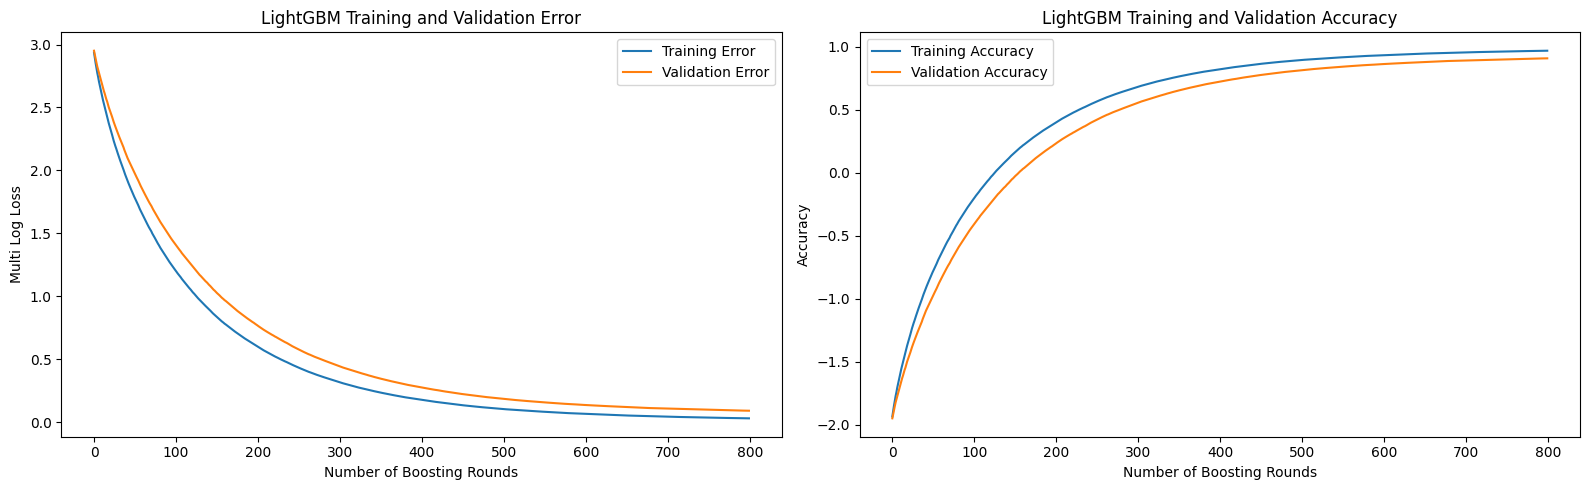

In [28]:
plt.figure(figsize=(16, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(evals_result["training"]["multi_logloss"], label="Training Error")
plt.plot(evals_result["valid_1"]["multi_logloss"], label="Validation Error")
plt.title("LightGBM Training and Validation Error")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("Multi Log Loss")
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(np.arange(num_boost_round), [1 - loss for loss in evals_result["training"]["multi_logloss"]], label="Training Accuracy")
plt.plot(np.arange(num_boost_round), [1 - loss for loss in evals_result["valid_1"]["multi_logloss"]], label="Validation Accuracy")
plt.title("LightGBM Training and Validation Accuracy")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred = clf_gbm.predict(X_test)
y_pred.shape
if y_pred.ndim > 1:  # 检查是否为多类输出
    y_pred_labels = np.argmax(y_pred, axis=1)  # 对于多类问题
else:
    y_pred_labels = (y_pred > 0.5).astype(int)  # 对于二分类问题

y_pred_labels.shape
y_test
accuracy_ = accuracy_score(y_pred_labels,y_test)
accuracy_
train_accuracy

(15506, 20)

(15506,)

8071      7
12922    19
21652     0
65458     2
47273     7
         ..
35639    14
38373     5
3657     12
48278    15
55717    17
Name: ship_true, Length: 15506, dtype: int32

0.9832967883399975

0.9832967883399975

0.9999516308466214

In [ ]:
lgb.create_tree_digraph(clf_gbm, tree_index=1)

                 Feature  Importance
26          acceleration      163549
3                  speed       84844
27      angular_velocity       33096
5             longtitude       32380
6               latitude       32206
4                   time       27245
7       offset_longitude       23091
8        offset_latitude       22202
2                heading       21228
25         jamming_score        6434
0                ship_id        5477
22  reconnaissance_score        4968
24       intercept_score        3968
23       precision_score        3295
11                  防空导弹        1518


<Figure size 1200x600 with 0 Axes>

<BarContainer object of 15 artists>

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Top Feature Importances')

e:\Anaconda\envs\project\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38450 (\N{CJK UNIFIED IDEOGRAPH-9632}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\project\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\project\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\project\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24377 (\N{CJK UNIFIED IDEOGRAPH-5F39}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


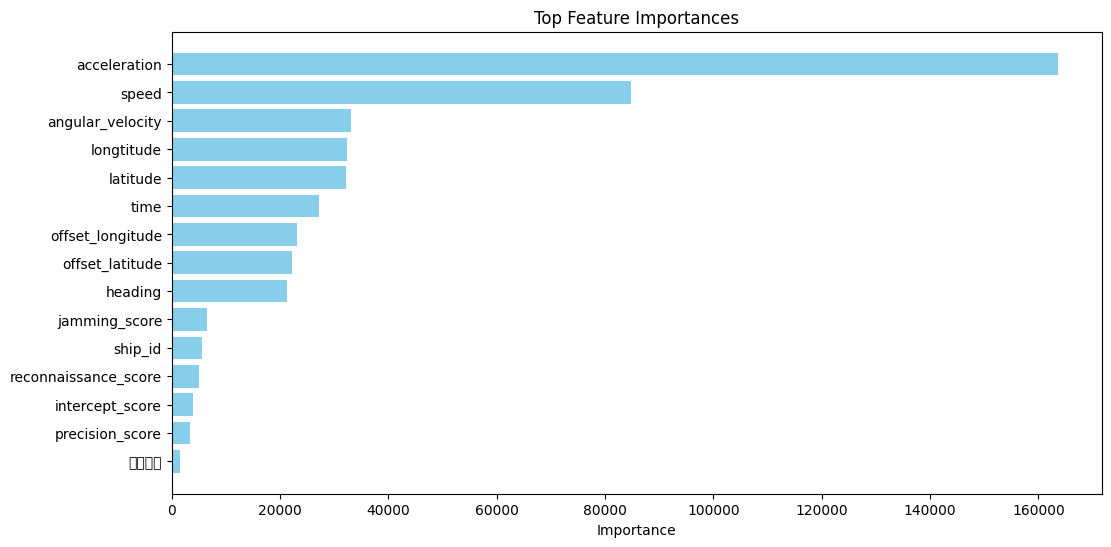

In [34]:
from matplotlib import pyplot as plt


importances = clf_gbm.feature_importance()
feature_names = X_train.columns  # 获取特征名称

# 创建一个 DataFrame 来存储特征名称和其重要性
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 输出前几个重要特征
top_n = 15  # 可调整显示的特征数量
print(feature_importance_df.head(top_n))

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()  # 反转 y 轴，使最重要的特征在顶部
plt.show()

### 可视化一下这颗决策树

In [32]:
import pydotplus
from IPython.display import display, Image
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_columns,
    filled=True,
    rounded=True,
    special_characters=True  # 处理特殊字符（例如中文）  
)

ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

In [ ]:
ship_capabilities = {
    "航母1": [30, 20, 10, 800, 8, 6, 30],
    "航母2": [60, 40, 20, 1000, 6, 5, 35],
    "航母3": [100, 100, 100, 600, 9, 4, 40],
    "巡洋舰1": [128, 128, 96, 1200, 3, 3, 800],
    "巡洋舰2": [150, 250, 200, 1000, 2, 4, 1200],
    "巡洋舰3": [120, 120, 120, 800, 4, 4, 1000],
    "驱逐舰1": [20, 20, 20, 600, 1, 1, 300],
    "驱逐舰2": [30, 40, 50, 650, 1, 2, 350],
    "驱逐舰3": [60, 50, 40, 700, 2, 1, 400],
    "驱逐舰4": [70, 80, 90, 750, 2, 2, 450],
    "护卫舰1": [0, 60, 70, 500, 3, 4, 400],
    "护卫舰2": [70, 60, 0, 600, 4, 3, 420],
    "护卫舰3": [60, 0, 60, 550, 2, 5, 380],
    "护卫舰4": [0, 75, 75, 500, 5, 5, 450],
    "护卫舰5": [80, 75, 0, 650, 2, 2, 350],
    "护卫舰6": [90, 90, 100, 800, 3, 3, 390],
    "护卫舰7": [100, 100, 60, 450, 4, 4, 500],
    "潜艇1": [40, 0, 0, 0, 5, 5, 100],
    "潜艇2": [0, 50, 0, 200, 4, 6, 30],
    "潜艇3": [0, 0, 60, 300, 7, 2, 50],
}

ship_weights = {}
for ship, capabilities in ship_capabilities.items():
    attack_weight = capabilities[0] + capabilities[1] + capabilities[2]  # 舰空能力
    defense_weight = capabilities[3]  # 近防能力
    electronic_weight = capabilities[4] + capabilities[5]  # 电子能力
    radar_weight = capabilities[6]  # 雷达能力
    
    # 计算综合权重，这里可以应用自己的算法
    total_weight = attack_weight * 0.5 + defense_weight * 0.3 + electronic_weight * 0.1 + radar_weight * 0.1
    ship_weights[ship] = {
        "A": total_weight,  # 假设A意图对应攻击
        "B": defense_weight,  # 假设B意图对应防空
        "C": electronic_weight,  # 假设C意图对应电子战
        "D": radar_weight,  # 假设D意图对应雷达相关
    }

for ship, weights in ship_weights.items():
    print(f"{ship}: {weights}")
